In [44]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps
from sklearn.metrics import auc
from sklearn.svm import SVC
from pathlib import Path
import numpy as np
import seaborn as sns
base_folder = 'results/schaefer400'
atlas_basename = 'schaefer400'
output = Path('results')
atlas_networks = [dir_ for dir_ in output.iterdir() if
                        dir_.is_dir() and atlas_basename in dir_.name]
perm_array = [5, 0, 2, 8, 1, 3, 4, 7, 6]
atlas_networks = [atlas_networks[i] for i in perm_array]
output = output / atlas_basename
subjects_df = pd.read_csv('clinical_data.csv')
subjects_df = subjects_df.astype({'id': int})
subjects_df = subjects_df.set_index('id')
filename = Path('global_measures.csv')

networks_names = {"Global": "Global", "SalVentAttn": "Salience/Ventral Attention",
                  "DorsAttn": "Dorsal Attention", "Default": "Default",
                  "Limbic": "Limbic", "SalVentAttnLH": "Salience/Ventral Attention (Left Hemisphere)",
                  "Vis": "Visual", "SomMot": "Somatomotor", "Cont": "Frontoparietal"
                }
networks_nce = {
      "SalVentAttnLH": "language", "SalVentAttn": "executive", "DorsAttn": "attention", "SomMot": "executive",
      "Cont": "visuospatial", "Default": "memory", "Vis": "visuospatial", "Limbic": "memory", "Global": "attention"
    }

In [2]:
def add_curve(graph_densities, measure, lower_error, upper_error, group, color_index, ax):
    ax.plot(graph_densities, measure, label=group, color=f'C{color_index}')
    ax.plot(graph_densities, lower_error, alpha=0.1, color=f'C{color_index}')
    ax.plot(graph_densities, upper_error, alpha=0.1, color=f'C{color_index}')
    ax.legend()
    ax.fill_between(graph_densities, lower_error, upper_error, alpha=0.2)

    
def add_statistical_significance(p_at_thresholds, ax, significance_levels, eps=1e-4):
    pvalues = p_at_thresholds[p_at_thresholds.columns[0]]
    labels = ['*' * i for i in range(len(significance_levels), 0, -1)]
    significance_levels.insert(0, 0.0)
    significance_levels.append(1.)
    labels.append('ns')
    categorized_pvalues = pd.cut(pvalues, significance_levels, right=False, labels=labels)
    spacing = 0.1
    if len(pvalues) > 1:
        spacing = pvalues.index[1] - pvalues.index[0] + eps

    significance_bar(ax, categorized_pvalues, labels, spacing)
    
    
def significance_bar(ax, categorized_pvalues, labels, spacing):
    line_y = ax.get_ylim()[1]
    min_threshold = categorized_pvalues.index[0]
    # Use light grey for *, dark grey for **, and black for ***
    colors = {label: col for label, col in zip(labels, colormaps.get_cmap('Greys')(np.linspace(0.8, 0.2, len(labels))))}
    for label in labels:
        significant_values = categorized_pvalues[categorized_pvalues == label]
        # Build a list of tuples with the start and end of each significant region
        if len(significant_values) > 0 and label not in 'ns':
            significant_regions = [(significant_values.index[0], significant_values.index[0])]
            for i, threshold in enumerate(significant_values.index):
                if i > 0:
                    if threshold - significant_values.index[i - 1] > spacing:
                        significant_regions.append((threshold, threshold))
                    else:
                        significant_regions[-1] = (significant_regions[-1][0], threshold)
            
            significant_regions = [(start - spacing, end) for start, end in significant_regions]
            for start, end in significant_regions:
                if start < min_threshold:
                    start = min_threshold
                ax.plot((start, end), [line_y * 0.98, line_y * 0.98], linewidth=2, color=colors[label])

def get_network_name(atlas_basename, network):
    return network.lstrip(f'{atlas_basename}_') if is_network(network) else 'Global'


def is_network(atlas_name):
    return len(atlas_name.split('_')) > 1
                

In [15]:
def meshgrid(x, y, h=.02, offset=0.07):
    x_min, x_max = x.min() - offset, x.max() + offset
    y_min, y_max = y.min() - offset, y.max() + offset
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy


def add_svm_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    return ax.contourf(xx, yy, Z, **params)


def normalize_values(df, columns):
    df[columns] = df[columns].astype(float)
    for column in columns:
        df[column] = (df[column] - df[column].mean()) / df[column].std()
    return df


def get_measure_at_threshold(subjects_df, groups, measure_label, network, network_nce, filename):
    graph_density, nces, values, categories, group_mapping = 0.0, [], [], [], {}
    for j, group in enumerate(groups):
        group_df = subjects_df[subjects_df['group'] == group]
        group_mapping[group] = j
        group_network_measures = pd.read_pickle(network / f'{filename.stem}_{group}.pkl')
        measures_at_threshold = group_network_measures.sort_values(by='threshold').iloc[-1]
        if measure_label not in measures_at_threshold.index:
            continue
        graph_density = measures_at_threshold['threshold']
        nces.extend(group_df[network_nce].values)
        values.extend(measures_at_threshold[measure_label])
        categories.extend([group] * len(group_df))
    df = pd.DataFrame({'nce': nces, 'measure': values, 'group': categories}).dropna()
    df = normalize_values(df, ['nce', 'measure'])
    return graph_density, df, group_mapping


def loocv_svm(features, categories):
    svm = SVC()
    accuracies = []
    for i in range(len(features)):
        svm.fit(np.delete(features, i, axis=0), np.delete(categories, i))
        accuracies.append(svm.score(features[i].reshape(1, -1), categories[i].reshape(1, -1)))
    mean_accuracy, std_accuracy = np.mean(accuracies), np.std(accuracies)
    ste_accuracy = std_accuracy / np.sqrt(len(features))
    
    return mean_accuracy, ste_accuracy


def fit_and_plot_svm(df, cats_mapping, feature_list, plot=False, ax=None):
    df = df.replace({'group': cats_mapping})
    categories = df['group'].values
    means, stes = [], []
    for i, _ in enumerate(feature_list):
        features = df[feature_list[:i + 1]].values
        mean, ste = loocv_svm(features, categories)
        print(f'Mean accuracy for {feature_list[:i + 1]}: {mean} +/- {ste}')
        means.append(mean), stes.append(ste)
    
    if plot:
        features = df[feature_list].values
        plot_svm(features, categories, ax)
    
    return means, stes
    
def plot_svm(features, categories, ax):
    clf = SVC()
    clf.fit(features, categories)
    xx, yy = meshgrid(features[:, 0], features[:, 1])
    add_svm_contours(ax, clf, xx, yy, cmap='coolwarm', alpha=0.1)
    return clf


def add_group_to_plot(measures_values, group, color_index, measure_label, ax):
    group_values = measures_values[measures_values['group'] == group]
    densities, auc_value = group_values['threshold'].values, 0.0
    if measure_label in group_values.columns:
        measure_values = group_values[measure_label].values
        lower_error, upper_error = group_values[measure_label] - group_values[f'{measure_label}_ste'], \
                                   group_values[measure_label] + group_values[f'{measure_label}_ste']
        sorted_densities = np.argsort(densities)
        if group == 'covid':
            group = 'long-COVID'
        else:
            group = group.capitalize()
        add_curve(densities, measure_values, lower_error, upper_error, group, color_index, ax)
        if len(densities) > 1:
            auc_value = auc(densities[sorted_densities], measure_values[sorted_densities])
    return auc_value


### Classify with both local + global efficiency

In [14]:
def classify_with_efficiency(atlas_basename, networks_dirs, subjects_df,
                        networks_nce, filename):
    gains = {network.name: {} for network in networks_dirs}
    for network in networks_dirs:
        print(f'Processing {network.name}')
        network_basename = get_network_name(atlas_basename, network.name)
        if network_basename not in networks_nce:
            continue
        network_nce = networks_nce[network_basename]
        groups = sorted(subjects_df['group'].unique())
        measure_df, group_mapping = get_efficiency_at_threshold(subjects_df, groups, network,
                                                                            network_nce, filename)
        if not measure_df.empty:
            means_network, stes_network = fit_and_plot_svm(measure_df, group_mapping, ['nce', 'local_eff', 'global_eff'])
            gains[network.name] = means_network[-1] - means_network[0], abs(stes_network[-1] - stes_network[0])

    return gains

def get_efficiency_at_threshold(subjects_df, groups, network, network_nce, filename):
    nces, local_eff_values, global_eff_values, categories, group_mapping = [], [], [], [], {}
    for j, group in enumerate(groups):
        group_df = subjects_df[subjects_df['group'] == group]
        group_mapping[group] = j
        group_network_measures = pd.read_pickle(network / f'{filename.stem}_{group}.pkl')
        measures_at_threshold = group_network_measures.sort_values(by='threshold').iloc[-1]
        if 'global_efficiency' not in measures_at_threshold.index or 'avg_local_efficiency' not in measures_at_threshold.index:
            continue
        nces.extend(group_df[network_nce].values)
        local_eff_values.extend(measures_at_threshold['avg_local_efficiency'])
        global_eff_values.extend(measures_at_threshold['global_efficiency'])
        categories.extend([group] * len(group_df))
    df = pd.DataFrame({'nce': nces, 'local_eff': local_eff_values, 'global_eff': global_eff_values, 'group': categories}).dropna()
    df = normalize_values(df, ['nce', 'local_eff', 'global_eff'])
    
    return df, group_mapping

### Additive analysis

In [56]:
# Classify groups with the global composite
# Then add efficiency measures from networks, one by one
# And see if the accuracy improves
def add_networks_to_global(subjects_df, measure_label, networks_dirs, networks, filename):
    groups = sorted(subjects_df['group'].unique())
    _, measure_df, group_mapping = get_measure_at_threshold(subjects_df, groups, measure_label, networks_dirs['Global'],
                                                                            'global', filename)
    measure_df = measure_df.rename(columns={'measure': 'Global', 'nce': 'global_nce'})
    for network in networks:
        network_dir = networks_dirs[network]
        _, network_measure_df, _ = get_measure_at_threshold(subjects_df, groups, measure_label, network_dir,
                                                            'global', filename)
        measure_df[network] = network_measure_df['measure']
    features = ['global_nce'] + [network for network in networks] + ['Global']
    means, stes = fit_and_plot_svm(measure_df, group_mapping, features)
    # Plot means and stes
    fig, ax = plt.subplots()
    ax.errorbar(range(len(means)), means, yerr=stes, fmt='o')
    ax.set_xticks(range(len(means)))
    labels = ['global_nce'] + ['+'.join(features[:i + 1]) for i in range(len(features)) if i > 0]
    ax.set_xticklabels(labels, rotation=90)
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Global efficiency')
    plt.show()

In [ ]:
networks_dirs = {get_network_name(atlas_basename, network.name): network for network in atlas_networks}
networks = ['SalVentAttn', 'DorsAttn', 'Default']
add_networks_to_global(subjects_df, 'global_efficiency', networks_dirs, networks, filename)

### Plots

In [32]:
def plot_nce_to_measure(atlas_basename, networks_dirs, networks_names, subjects_df, measure_label, measure_desc,
                        networks_nce, output, filename):
    ncols, nrows = 2, -(-len(networks_dirs) // 2)
    fig, axes = plt.subplots(figsize=(15, 5 * nrows), nrows=nrows, ncols=ncols)
    gains = {network.name: {} for network in networks_dirs}
    for i, network in enumerate(networks_dirs):
        print(f'Processing {network.name}')
        ax = axes[i // 2, i % 2] if nrows > 1 else axes[i % 2]
        network_basename = get_network_name(atlas_basename, network.name)
        if network_basename not in networks_nce:
            continue
        network_nce = networks_nce[network_basename]
        groups = sorted(subjects_df['group'].unique())
        connection_density, measure_df, group_mapping = get_measure_at_threshold(subjects_df, groups, measure_label, network,
                                                                            network_nce, filename)
        plot_df = measure_df.copy().replace({'group': {'covid': 'long-COVID', 'control': 'Control'}})
        sns.scatterplot(data=plot_df, x='nce', y='measure', hue='group', ax=ax)
        if not measure_df.empty:
            means_network, stes_network = fit_and_plot_svm(measure_df, group_mapping, ['nce', 'measure'], plot=True, ax=ax)
            gains[network.name] = means_network[-1] - means_network[0], abs(stes_network[-1] - stes_network[0])
        ax.legend()
        ax.set_title(f'{networks_names[network_basename]}', font='Nimbus Roman')
        ax.set_ylabel(f'{measure_desc} at {connection_density * 100:.0f}%', font='Nimbus Roman', fontsize=15)
        ax.set_xlabel(f'{network_nce} score', font='Nimbus Roman', fontsize=15)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xticks(ax.get_xticks()[1:-1])
        ax.set_yticks(ax.get_yticks()[1:-1])
        ax.set_yticklabels(ax.get_yticks(), font='Nimbus Roman', fontsize=11)
        ax.set_xticklabels(ax.get_xticks(), font='Nimbus Roman', fontsize=12)
        ax.get_legend().remove()
    fig.suptitle(measure_desc)
    #fig.savefig(output / f'NCE_to_{measure_label}.png')
    plt.show()

    return gains

In [52]:
def plot_measure(atlas_basename, networks_dirs, networks_names, measure_label, measure_desc, output, filename):
    ncols, nrows = 2, -(-len(networks_dirs) // 2)
    fig, axes = plt.subplots(figsize=(15, 5 * nrows), nrows=nrows, ncols=ncols)
    aucs = {network.name: {} for network in networks_dirs}
    for i, network in enumerate(networks_dirs):
        measures_values = pd.read_csv(network / filename.name, index_col=0)
        ax = axes[i // 2, i % 2] if nrows > 1 else axes[i % 2]
        groups = sorted(measures_values['group'].unique())
        for color_index, group in enumerate(groups):
            aucs[network.name][group] = add_group_to_plot(measures_values, group, color_index, measure_label, ax)
        if f'{measure_label}_p' in measures_values.columns:
            p_at_thresholds = measures_values[['threshold', f'{measure_label}_p']].drop_duplicates().set_index(
                'threshold')
            add_statistical_significance(p_at_thresholds, ax, significance_levels=[0.001, 0.005, 0.01])
        network_basename = get_network_name(atlas_basename, network.name)
        ax.set_title(f'{networks_names[network_basename]}', font='Nimbus Roman', fontstyle='italic')
        ax.set_xlabel('Connection density (%)', fontsize=15, font='Nimbus Roman')
        ax.set_ylabel(measure_desc, fontsize=15, font='Nimbus Roman')
        ax.spines['top'].set_visible(False), ax.spines['right'].set_visible(False)
        ax.set_xticks(ax.get_xticks()[1:-1])
        ax.set_yticks(ax.get_yticks()[1:-1])
        ax.set_yticklabels([f'{tick:.2f}' for tick in ax.get_yticks()], font='Nimbus Roman', fontsize=11)
        ax.set_xticklabels([f'{tick * 100:.0f}' for tick in ax.get_xticks()], font='Nimbus Roman', fontsize=12)
    fig.suptitle(measure_desc)
    fig.savefig(output / f'{measure_label}.png')
    plt.show()

    return aucs

In [19]:
classify_with_efficiency(atlas_basename, atlas_networks, subjects_df, networks_nce, filename)

Processing schaefer400
Mean accuracy for ['nce']: 0.7142857142857143 +/- 0.04929039709588245
Mean accuracy for ['nce', 'measure']: 0.75 +/- 0.0472455591261534
Processing schaefer400_SalVentAttn
Mean accuracy for ['nce']: 0.8 +/- 0.0447213595499958
Mean accuracy for ['nce', 'measure']: 0.7875 +/- 0.04573616594118925
Processing schaefer400_DorsAttn
Mean accuracy for ['nce']: 0.7142857142857143 +/- 0.04929039709588245
Mean accuracy for ['nce', 'measure']: 0.7619047619047619 +/- 0.04647143204516824
Processing schaefer400_Default
Mean accuracy for ['nce']: 0.6951219512195121 +/- 0.05083778892069367
Mean accuracy for ['nce', 'measure']: 0.7439024390243902 +/- 0.04820074893633732
Processing schaefer400_Limbic
Mean accuracy for ['nce']: 0.6951219512195121 +/- 0.05083778892069367
Mean accuracy for ['nce', 'measure']: 0.6707317073170732 +/- 0.051897023284694865
Processing schaefer400_SalVentAttnLH
Mean accuracy for ['nce']: 0.691358024691358 +/- 0.05132589007920359
Mean accuracy for ['nce', 'mea

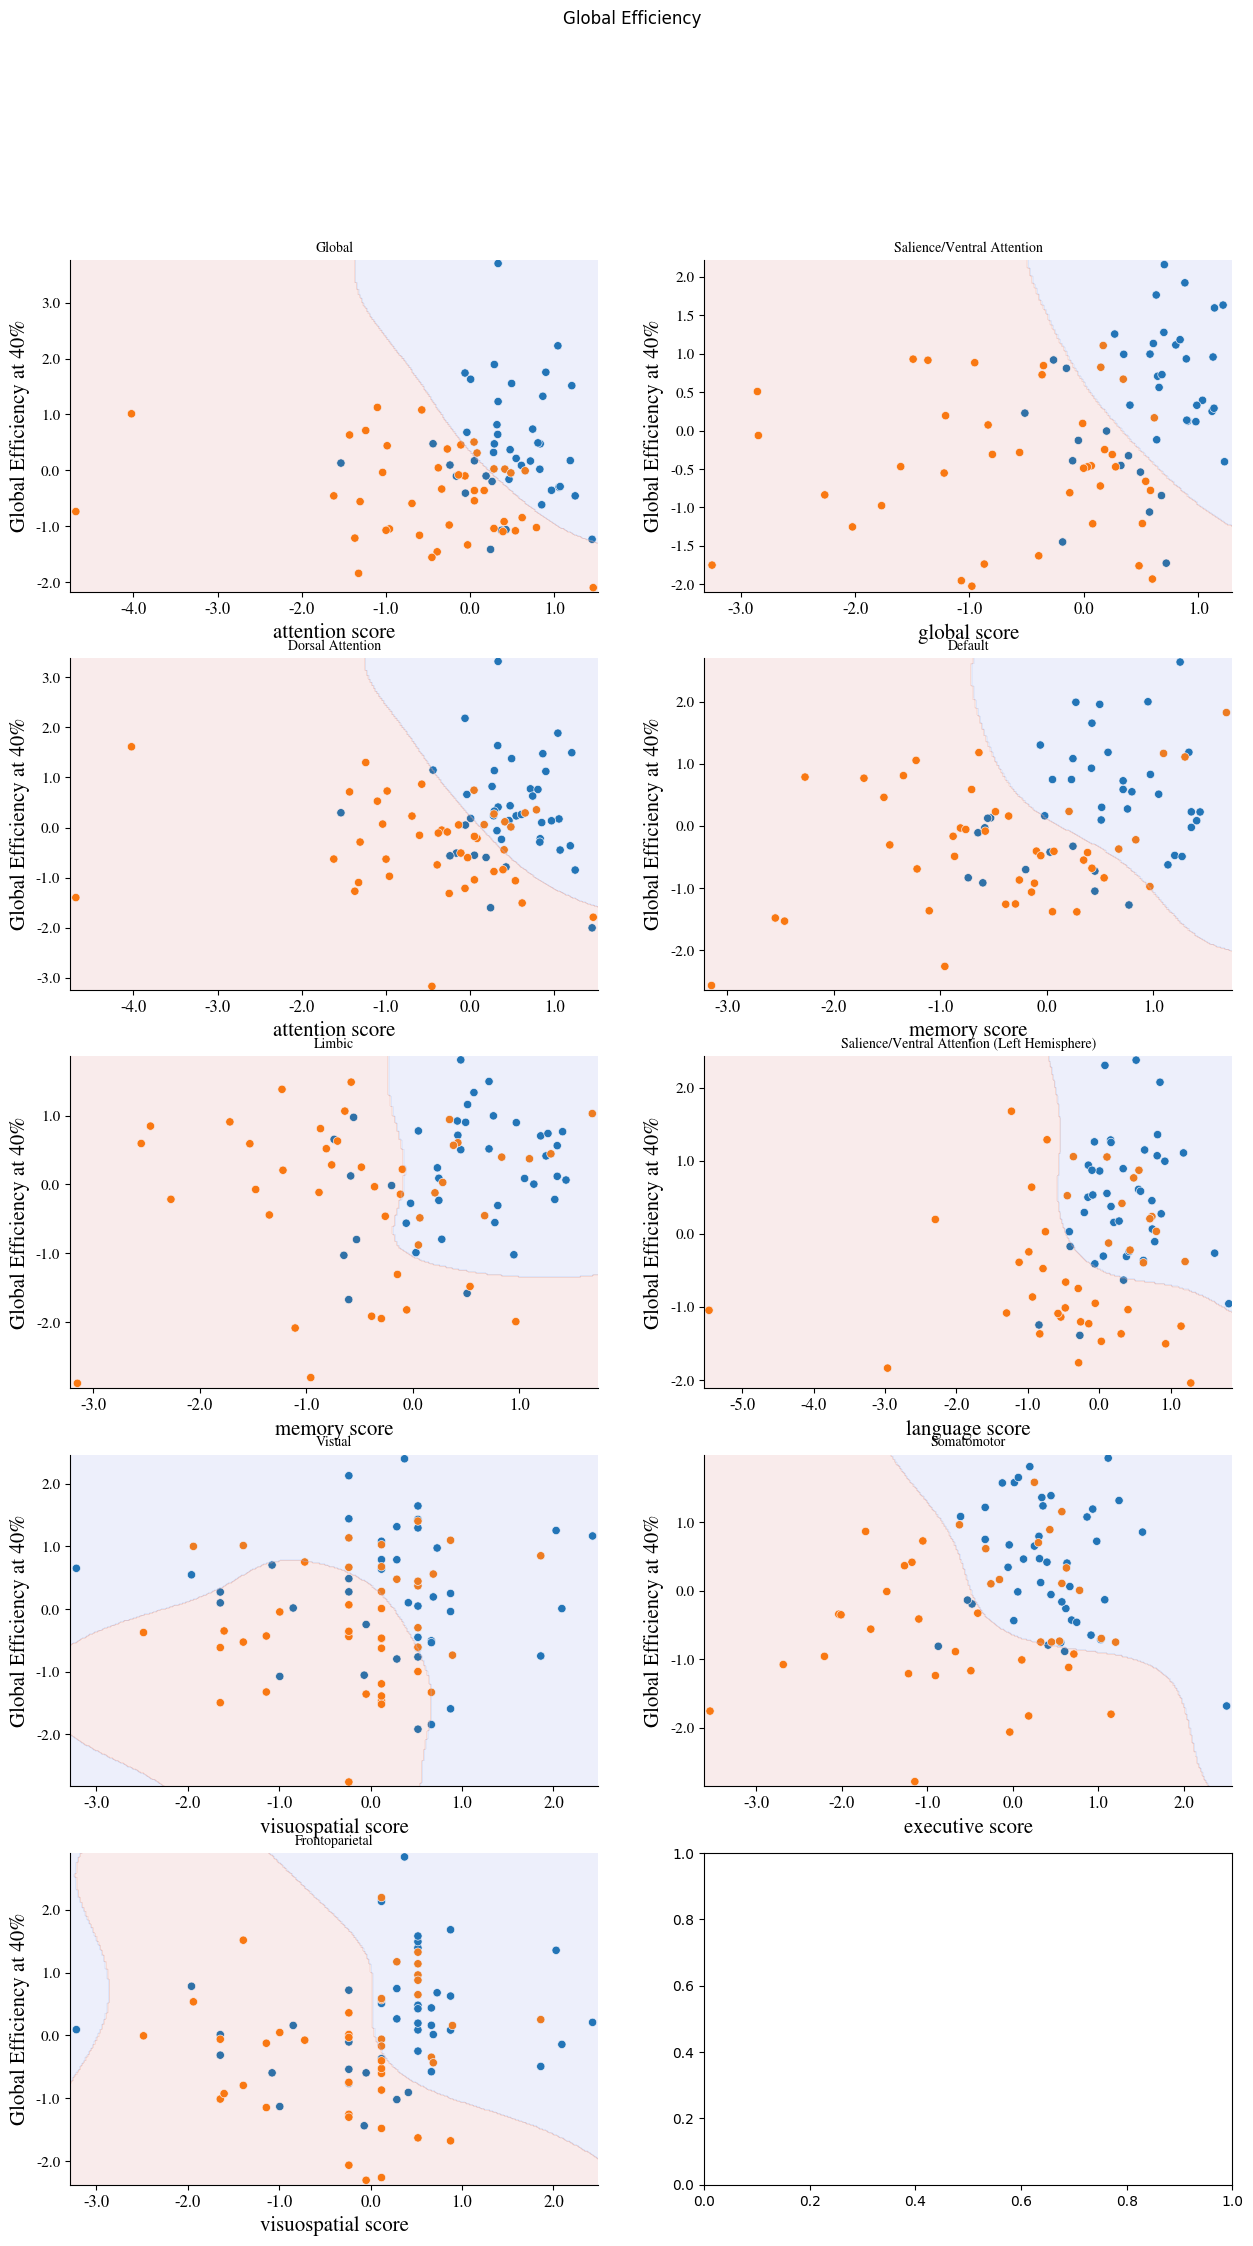

{'schaefer400': (0.0357142857142857, 0.002044837969729048),
 'schaefer400_SalVentAttn': (-0.012500000000000067, 0.0010148063911934457),
 'schaefer400_DorsAttn': (0.04761904761904756, 0.0028189650507142103),
 'schaefer400_Default': (0.04878048780487809, 0.002637039984356347),
 'schaefer400_Limbic': (-0.024390243902438935, 0.0010592343640011964),
 'schaefer400_SalVentAttnLH': (0.04938271604938271, 0.0026338754034865783),
 'schaefer400_Vis': (-0.0843373493975903, 0.001357652444732349),
 'schaefer400_SomMot': (0.012048192771084376, 0.0005526400124667916),
 'schaefer400_Cont': (-0.02409638554216864, 0.0005536397003143845)}

In [35]:
plot_nce_to_measure(atlas_basename, atlas_networks, networks_names, subjects_df, 'global_efficiency', 'Global Efficiency', networks_nce, output, filename)

In [23]:
plot_nce_to_measure(atlas_basename, atlas_networks, networks_names, subjects_df, 'avg_local_efficiency', 'Avg. Local Efficiency', networks_nce, output, filename)

In [28]:
plot_measure(atlas_basename, atlas_networks, networks_names, 'avg_local_efficiency', 'Avg. Local efficiency', output, filename)

In [29]:
plot_measure(atlas_basename, atlas_networks, networks_names, 'global_efficiency', 'Global efficiency', output, filename)